In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from collections import defaultdict
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# CRISP-DM Process
**Business Understanding:**
From the datasets we can get a better knowledge how we can set the rental price for peroperties and figure out some interesting patterns and features how Seattle Airbnb prices the properties. Three business aspect questions were asked before diving into the dataset:

* Is there any relation to the dates and pricing?
* Does it affect by the locality or the neighborhood?
* Does it gets affected by age of listing

**Data Understanding**：Seatle dataset contains information about 8494 listings. Datasets were investigated before any preprocessing.

**Prepare Data:** Including data cleaning, converting data into usable formats, removing data. Please refer respective menthods for detail.

**Data Analyis:** Used Data Visualizations and graphs for Analysis of the data. Please refer plots for detail.

**Result**: Detaiked Discussion about the result can be found on this blog post https://medium.com/@twinklek55/what-affects-the-airbnb-prices-bf7eb906862b

In [2]:
path = "./seattle/"
df = pd.read_csv(path+"listings.csv")
calender = pd.read_csv(path+"calendar.csv")
review = pd.read_csv(path+"reviews.csv")

## Data Understanding

In [107]:
df.shape
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [108]:
calender.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Data Preprocessing

In [109]:
def convertDate(dataframe, col):
    """
    This Method seprates Datetimestamp into Day, Week, year and add those as seprate column into the dataframe
    Imput: Dataframe and column containing datetime stamp
    output: Dataframe
    """
    suffixes = ['y','m','d']
    date = pd.to_datetime(dataframe[col])
    dataframe['days'] = date.dt.dayofweek
    dataframe['week'] = date.dt.week
    # Creating new columns for day week ad year this will help us get deeper dive into the data as we are looking answer does date affects pays any role in price. or not 
    split_df = dataframe[col].str.split('-',expand=True).rename(columns ={idx:'%s_%s' % (col, suffix) for idx, suffix in enumerate (suffixes)}).applymap(float)
    dataframe = pd.concat((dataframe.drop([col],axis=1),split_df),axis=1)
    
    return dataframe

In [110]:
def cleanPrice(dataframe,col):
    """
    Removes Doller Symbol and converts price in Integer format
    Imput : dataframe, column containing the price
    ouput : Dataframe
    """
    removeCurrency = lambda x:float(x.lstrip('$').replace(",",""))
    dataframe[col] = dataframe[col].apply(removeCurrency)
    
    return dataframe

In [111]:
def convertLower(dataframe):
    """
    Converts the string values of dataframe to lower case
    Input: Dataframe
    Output: Dataframe
    """
    dataframe = dataframe.applymap(lambda x: str.lower(x) if isinstance(x,str) else x)
    return dataframe

In [112]:
calender.dropna(inplace = True) # Dropping nan values here will not affect that much as it is very less in this option,hoever fillig the valus might make the generate biased result
calender = convertLower(calender)
calender = cleanPrice(calender,"price")
calender = convertDate(calender , 'date')

calender.head()

,listing_id,available,price,days,week,date_y,date_m,date_d
0,241032,t,85.0,0,1,2016.0,1.0,4.0
1,241032,t,85.0,1,1,2016.0,1.0,5.0
9,241032,t,85.0,2,2,2016.0,1.0,13.0
10,241032,t,85.0,3,2,2016.0,1.0,14.0
14,241032,t,85.0,0,3,2016.0,1.0,18.0


In [113]:
df = convertDate(df,'host_since')
df = convertLower(df)
df = cleanPrice(df,'price')

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,days,week,host_since_y,host_since_m,host_since_d
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,stylish queen anne apartment,NaN,make your self at home in this charming one-be...,make your self at home in this charming one-be...,none,NaN,...,moderate,f,f,2,4.07,3.0,32.0,2011.0,8.0,11.0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,bright & airy queen anne apartment,chemically sensitive? we've removed the irrita...,"beautiful, hypoallergenic apartment in an extr...",chemically sensitive? we've removed the irrita...,none,"queen anne is a wonderful, truly functional vi...",...,strict,t,t,6,1.48,3.0,8.0,2013.0,2.0,21.0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,new modern house-amazing water view,new modern house built in 2013. spectacular s...,"our house is modern, light and fresh with a wa...",new modern house built in 2013. spectacular s...,none,upper queen anne is a charming neighborhood fu...,...,strict,f,f,2,1.15,3.0,24.0,2014.0,6.0,12.0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,queen anne chateau,a charming apartment that sits atop queen anne...,NaN,a charming apartment that sits atop queen anne...,none,NaN,...,flexible,f,f,1,NaN,2.0,45.0,2013.0,11.0,6.0
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,charming craftsman 3 bdm house,cozy family craftman house in beautiful neighb...,cozy family craftman house in beautiful neighb...,cozy family craftman house in beautiful neighb...,none,we are in the beautiful neighborhood of queen ...,...,strict,f,f,1,0.89,1.0,48.0,2011.0,11.0,29.0


# Data Aalysis

## Neighboorhd and Municipalty

In [114]:
city_info = df.groupby('city')['price']
city_info.mean()

city
ballard, seattle         116.000000
phinney ridge seattle     60.000000
seattle                  128.046182
seattle                   97.500000
west seattle             110.000000
西雅图                       38.000000
Name: price, dtype: float64

In [115]:
df[[x for x in df.columns if 'neighb' in x]]

,neighborhood_overview,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,NaN,queen anne,queen anne,west queen anne,queen anne
1,"queen anne is a wonderful, truly functional vi...",queen anne,queen anne,west queen anne,queen anne
2,upper queen anne is a charming neighborhood fu...,queen anne,queen anne,west queen anne,queen anne
3,NaN,queen anne,queen anne,west queen anne,queen anne
4,we are in the beautiful neighborhood of queen ...,queen anne,queen anne,west queen anne,queen anne
5,this part of queen anne has wonderful views an...,queen anne,queen anne,west queen anne,queen anne
6,"close restaurants, coffee shops and grocery st...",queen anne,queen anne,west queen anne,queen anne
7,we are centrally located between downtown and ...,queen anne,queen anne,west queen anne,queen anne
8,walking score: 92 4 blocks from kerry park fam...,queen anne,queen anne,west queen anne,queen anne
9,"queen anne is a wonderful, truly functional vi...",queen anne,queen anne,west queen anne,queen anne


(0, 400)

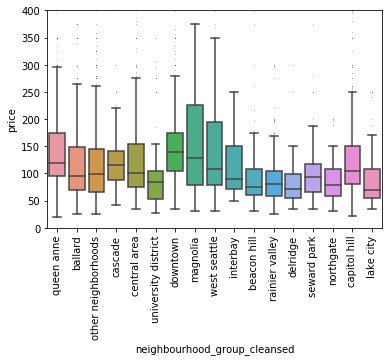

In [116]:
ax = seaborn.boxplot(data=df,x='neighbourhood_group_cleansed',y='price',fliersize=0.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(0,400)

# 

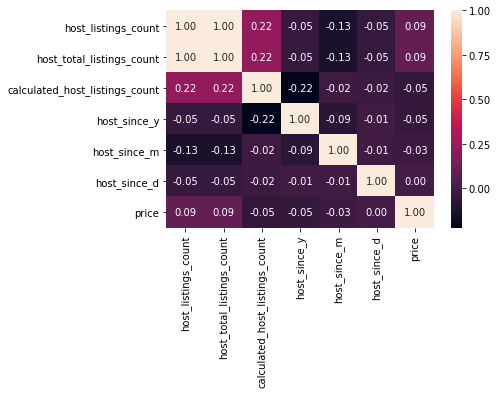

In [118]:
host_data = df[[x for x in df.columns if 'host' in x]+['price']].drop(['host_id'],axis=1)
seaborn.heatmap(host_data.corr(),fmt='0.2f', annot = True)

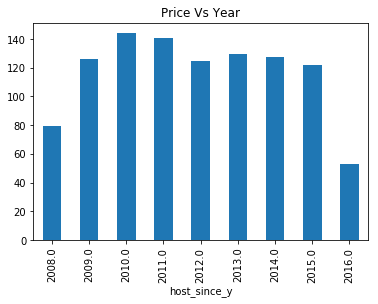

In [121]:
year_price = df.groupby('host_since_y')['price'].mean()
year_price.plot.bar(title="Price Vs Year")

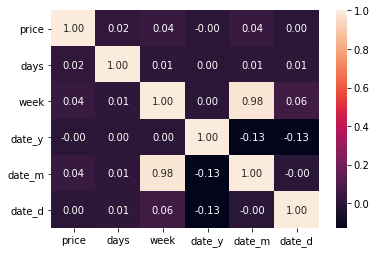

In [123]:
seaborn.heatmap(calender.drop('listing_id',axis=1).corr(),fmt='0.2f',annot=True)

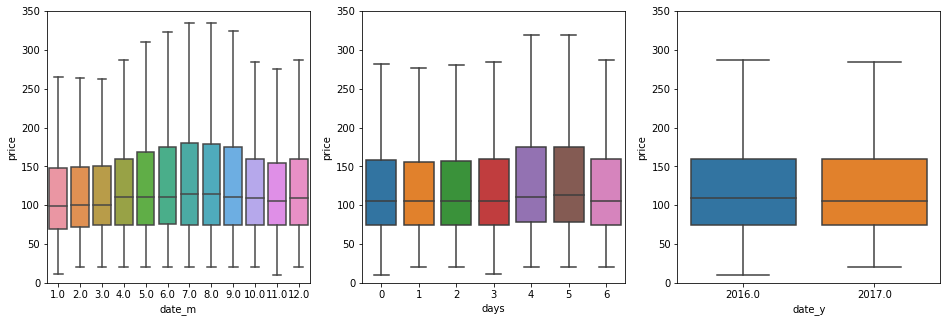

In [133]:
fig,axs = plt.subplots(1,3, figsize=(16,5))
seaborn.boxplot(data = calender,x="date_m",y="price",ax=axs[0],fliersize=0)
seaborn.boxplot(data = calender,x="days",y="price",ax=axs[1],fliersize=0)
seaborn.boxplot(data = calender,x="date_y",y="price",ax=axs[2],fliersize=0)
for ax in axs:
    ax.set_ylim(0,350)